# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [2]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [3]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 11248 / 11441 MB available


In [4]:
cuda_kernel = """
__global__ void addMatrixKernel (float *A, float *b, float *f, int n)
{
    unsigned int i = blockIdx.y * blockDim.y + threadIdx.y;

    double sum = 0.0;
    for (int k = 0; k < n; ++k)
    {
        int j = i*n + k;
        sum += A[j] * b[k];
    }
    f[i] = sum;
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("addMatrixKernel")

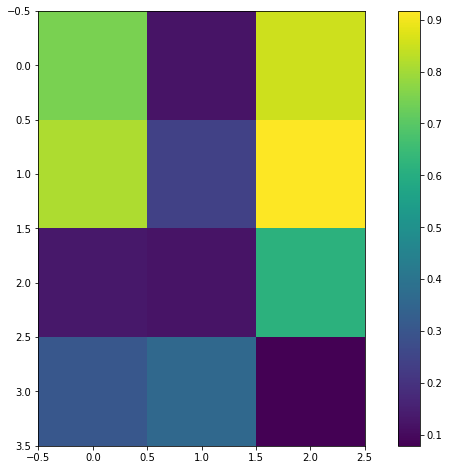

In [5]:
#Size of our test
m = 4
n = 3

#Create test input / output data
a = np.random.random((m, n)).astype(np.float32)
b = np.random.random((n, 1)).astype(np.float32)
c = np.empty((m, 1)).astype(np.float32)

fig = plt.figure(figsize=(12, 8))
plt.imshow(a)
plt.colorbar()

In [ ]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

#Allocate output data
c_g = GPUArray(c.shape, np.float32)

blocks = 1
block_size = (1, blocks, 1)
grid_size = (1, m//blocks, 1)

print(block_size)
print(grid_size)
print(m)

In [25]:
#Execute program on device
kernel(a_g, b_g, c_g, np.int32(n),  block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

array([[0.72556555],
       [0.872082  ],
       [0.4092404 ],
       [0.43688858]], dtype=float32)

In [26]:
#Compute reference using Numpy
c_ref = a.dot(b)

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [[0.72556555]
 [0.872082  ]
 [0.4092404 ]
 [0.43688858]]
Ref =  [[0.72556555]
 [0.872082  ]
 [0.4092404 ]
 [0.4368886 ]]
Sad =  2.9802322e-08


In [13]:
print(a.shape)
print(b.shape)
print(c.shape)
print(c_ref.shape)

(4, 3)
(3, 1)
(4, 1)
(4, 1)


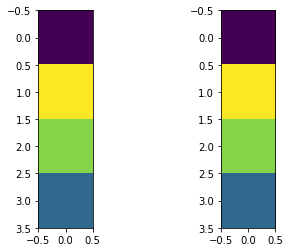

In [14]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)